In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
# Reflect tables into SQLAlchemy ORM
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

# Set up automap_base to reflect the database components
Base = automap_base()
Base.prepare(engine, reflect=True)

# Let's take a look at those keys and see what the heck is going on!
Base.classes.keys()

['measurement', 'station']

In [5]:
# Assign keys to classes
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Start a session to query the database
session = Session(engine)

In [7]:
# Let's check to see if we're talking

first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fa8a078d208>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

# Climate Analysis

In [27]:
# Climate Analysis

# Get most recent date
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent


query_date = dt.date(2017, 8, 3) - dt.timedelta(days=365)
print(query_date)
# Remove hard coding, time permitting

2016-08-03


In [9]:
# Gather data for latest 12 months of prcp data in database
working_data = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= query_date).\
                order_by(Measurement.date).all()
working_data

# Load data into dataframe
prcp_data = pd.DataFrame(working_data)

prcp_data = prcp_data.set_index("date", drop=True)
prcp_data

,prcp
date,
2016-08-03,0.00
2016-08-03,0.02
2016-08-03,0.00
2016-08-03,0.02
2016-08-03,0.00
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


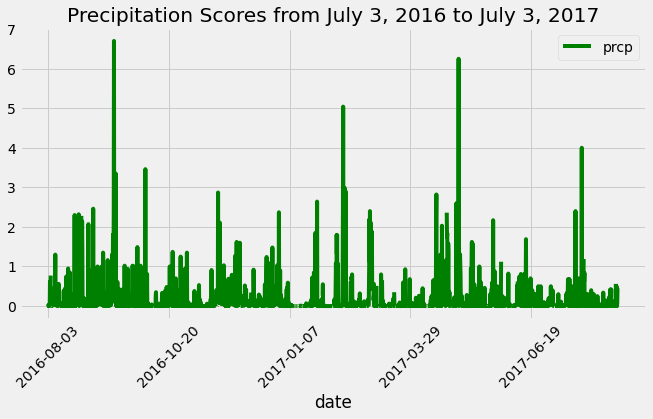

In [10]:
# Plot the dataframe

prcp_data.plot(figsize=(10, 5), color="green", rot=45, title="Precipitation Scores from July 3, 2016 to July 3, 2017")
plt.show() 

In [11]:
# Get summary statistics for datafram
prcp_data.describe()

,prcp
count,2136.000000
mean,0.178516
std,0.457667
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [12]:
# Set up reference to talk to Station table
first_row = session.query(Station).first()
first_row.__dict__

station_data = session.query(Station.elevation, Station.latitude,\
                            Station.station, Station.longitude,\
                            Station.name, Station.id)

station_data = pd.DataFrame(station_data)
station_data

,elevation,latitude,station,longitude,name,id
0,3.0,21.27160,USC00519397,-157.81680,"WAIKIKI 717.2, HI US",1
1,14.6,21.42340,USC00513117,-157.80150,"KANEOHE 838.1, HI US",2
2,7.0,21.52130,USC00514830,-157.83740,"KUALOA RANCH HEADQUARTERS 886.9, HI US",3
3,11.9,21.39340,USC00517948,-157.97510,"PEARL CITY, HI US",4
4,306.6,21.49920,USC00518838,-158.01110,"UPPER WAHIAWA 874.3, HI US",5
5,19.5,21.33556,USC00519523,-157.71139,"WAIMANALO EXPERIMENTAL FARM, HI US",6
6,32.9,21.45167,USC00519281,-157.84889,"WAIHEE 837.5, HI US",7
7,0.9,21.31520,USC00511918,-157.99920,"HONOLULU OBSERVATORY 702.2, HI US",8
8,152.4,21.33310,USC00516128,-157.80250,"MANOA LYON ARBO 785.2, HI US",9


In [13]:
# How many stations are there?
station_id = session.query(Station.station).count()
station_id

9

In [14]:
# Station Activity
# List station and tobs counts in descending order

station_tobs_count = session.query(func.count(Measurement.tobs), Measurement.station).\
                group_by(Measurement.station).\
                order_by(desc(func.count(Measurement.tobs))).all()
station_tobs_count

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [15]:
# Which station has the highest count?

max_station = station_tobs_count[0][1]
max_station

# Station USC00519281 has the highest count of observations, WAIHEE 837.5, HI US

'USC00519281'

In [17]:
# Lowest, highest, average temp from max_station

highest = session.query(func.max(Measurement.tobs)).\
                    filter(Measurement.station == max_station).all()
highest = highest[0][0]

lowest = session.query(func.min(Measurement.tobs)).\
                    filter(Measurement.station == max_station).all()
lowest = lowest[0][0]

mean = session.query(func.avg(Measurement.tobs)).\
        filter(Measurement.station == max_station).all()
mean = mean[0][0]

waihee_sum = pd.DataFrame({
    "Station": [max_station],
    "Highest": [highest],
    "Lowest": [lowest],
    "Average": [mean]
})

waihee_sum

,Station,Highest,Lowest,Average
0,USC00519281,85.0,54.0,71.663781


In [19]:
# Design query to retrieve latest 12 months of tobs data

most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent # 2017-08-03
query_date = dt.date(2017, 8, 3) - dt.timedelta(days=365)
print(query_date)

# Ok, query_date set as variable. Let's set up a query

tobs_data = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
            filter(Measurement.date >= query_date).\
            filter(Measurement.station == max_station).all()
tobs_data = pd.DataFrame(tobs_data)
tobs_data

2016-08-03


,station,date,tobs
0,USC00519281,2016-08-03,77.0
1,USC00519281,2016-08-04,77.0
2,USC00519281,2016-08-05,81.0
3,USC00519281,2016-08-06,78.0
4,USC00519281,2016-08-07,78.0
...,...,...,...
367,USC00519281,2017-08-14,77.0
368,USC00519281,2017-08-15,77.0
369,USC00519281,2017-08-16,76.0
370,USC00519281,2017-08-17,76.0


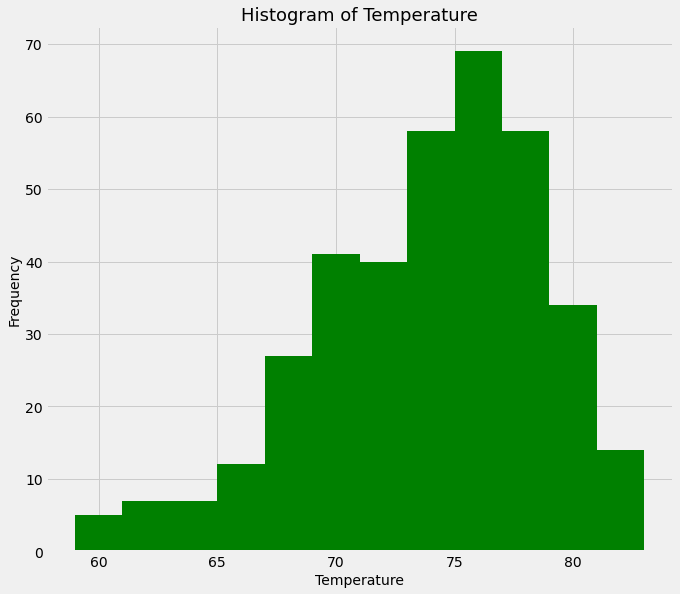

In [20]:
# Plot tobs data for most active station into a histogram with 12 bins

x = tobs_data['tobs']
station_max = plt.figure(figsize = (10, 9))
plt.hist(x, bins=12, color="green")
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Histogram of Temperature", fontsize=18)
plt.show()

Testing code for flask app in app.py

In [21]:
# Testing code for <start> and <start>/<end>
# Get some basic results with a test date of 2015-03-09

start = "2015-03-09"

results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.date >= start).\
            order_by(Measurement.date.desc()).all()

results

[(56.0, 87.0, 74.48725212464589)]

In [22]:
# Testing code for <start> and <start>/<end>
# Get some basic results with a test date of 2015-03-09

start = "2015-03-09"
end = "2016-09-11"

results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.date >= start, Measurement.date <= end).\
            order_by(Measurement.date.desc()).all()

results

[(56.0, 86.0, 74.54404291360814)]

In [28]:
session.close()

In [ ]:
# Datetime notes
datething = dt.datetime.strptime(date_str,'%Y-%m-%d')